# Importing Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pickle
import time
from scipy.ndimage.measurements import label

# Helper Functions

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),                                  
                                  cells_per_block=(cell_per_block, cell_per_block),                                   
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,
                        vis=True, feature_vec=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        #image = convert_color(cv2.imread(file), conv='BGR2RGB')
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=vis, feature_vec=feature_vec))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=vis, feature_vec=feature_vec)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
   
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def convert_color(img, conv='BGR2YCrCb'):
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2RGB':
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    

### Hog Sub Sampling Function

In [ ]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,400:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch = []
    if hog_channel == 'ALL':        
        for channel in range(ctrans_tosearch.shape[2]):
            ch.append(ctrans_tosearch[:,:,channel])
    else:
        ch.append(ctrans_tosearch[:,:,hog_channel])

    # Define blocks and steps as above
    nxblocks = (ch[0].shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch[0].shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hogs = []
    for channel in ch:
        hogs.append(get_hog_features(channel, orient, pix_per_cell, cell_per_block, feature_vec=False))
        
    window_list = [] 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat = []
            for hog in hogs:
                hog_feat.append(hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()) 
            
            hog_features = np.ravel(hog_feat)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                window_list.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return (window_list,draw_img)




# Reading Images

In [12]:
#Car Images Paths:
vehicles_path = './vehicles/*/'
non_vehicles_path = './non-vehicles/*/'

vehicles = glob.glob(vehicles_path + '*.png')
non_vehicles = glob.glob(non_vehicles_path + '*.png')
print('Number of Vehicle Images ',len(vehicles))
print('Number of Non Vehicle Images ',len(non_vehicles))



Number of Vehicle Images  8129
Number of Non Vehicle Images  8968


## Images Visualisation

Few Random Images: 
Shape of Vehicle Image:  (64, 64, 3)
Shape of Non Vehicle Image:  (64, 64, 3)


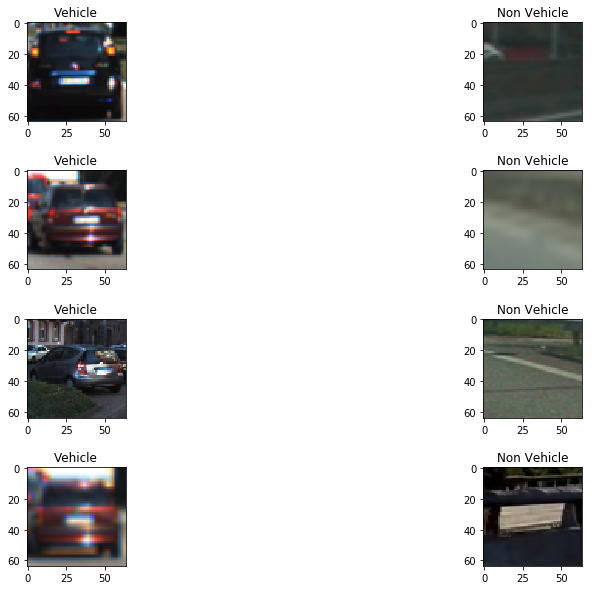

In [28]:
print("Few Random Images: ")
randomIndices = np.random.randint(8000,size=4)
f, axes = plt.subplots(4,2, figsize=(15,10))
plt.subplots_adjust(hspace=0.5)

for i in range(4):
    vehicle = mpimg.imread(vehicles[randomIndices[i]])
    non_vehicle= mpimg.imread(non_vehicles[randomIndices[i]])
    axes[i,0].imshow(vehicle)
    axes[i,0].set_title("Vehicle")
    axes[i,1].imshow(non_vehicle)
    axes[i,1].set_title("Non Vehicle")
print("Shape of Vehicle Image: ", vehicle.shape)
print("Shape of Non Vehicle Image: ", non_vehicle.shape)

## Parameters

In [3]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 32
histbin = 32
vis = False
feature_vec = True

# Extracting Features

In [10]:
#Car Features
car_features = extract_features(vehicles, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=True, hist_feat=False, hog_feat=True,
                        vis=vis, feature_vec=feature_vec)                      
                       
print("Car Features Extracted. Feature Vector Length: ", len(car_features[0]))
#Not Car Features
notcar_features = extract_features(non_vehicles, color_space=colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=True, hist_feat=False, hog_feat=True,
                        vis=vis, feature_vec=feature_vec)

print("Not Car Features Extracted.", len(notcar_features[0]))

C:\Users\aftab\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car Features Extracted. Feature Vector Length:  4044
Not Car Features Extracted. 4044


### HOG Visualisation

Parameters: 
ColorSpace:  YUV
Orientation:  9
Pixels per cell:  16
cells per block:  2


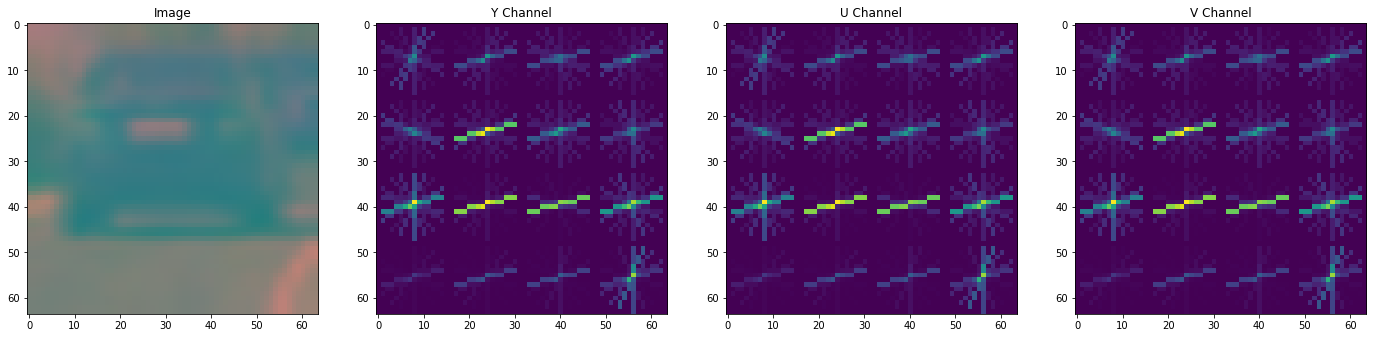

In [38]:
img = cv2.cvtColor(mpimg.imread(vehicles[1]), cv2.COLOR_RGB2YUV)

features1, hog_img1 = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

features2, hog_img2 = get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

features3, hog_img3 = get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

print('Parameters: ')
print('ColorSpace: ',colorspace)
print('Orientation: ',orient)
print('Pixels per cell: ',pix_per_cell)
print('cells per block: ',cell_per_block)

fig = plt.figure(1,figsize=(24,9))
plt.subplot(141)
plt.imshow(img)
plt.title('Image')
plt.subplot(142)
plt.imshow(hog_img1)
plt.title('Y Channel')
plt.subplot(143)
plt.imshow(hog_img1)
plt.title('U Channel')
plt.subplot(144)
plt.imshow(hog_img1)
plt.title('V Channel')

plt.imsave('YChannel.jpg', hog_img1)
plt.imsave('UChannel.jpg', hog_img2)
plt.imsave('VChannel.jpg', hog_img3)

# Training the model

### Setting  up Training and Test data

In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)    

print('Number of Training Samples: ', len(X_train))
print('Number of Testing Samples: ', len(X_test))

Number of Training Samples:  13677
Number of Testing Samples:  3420


### Training and Saving the Model

In [12]:
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

#Saving the Model
filename = 'svc_pickle.pkl'
scv_configs = {'svc': svc, 'scaler': X_scaler}
pickle_out = open(filename, 'wb')
pickle.dump(scv_configs, pickle_out)
pickle_out.close()
print('Model Saved: ', filename)

Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 4044
15.79 Seconds to train SVC...
Model Saved:  svc_pickle.pkl


### Testing the Model

In [13]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9822
My SVC predicts:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  1.  1.  1.  1.  0.  0.  1.]
0.0 Seconds to predict 10 labels with SVC


# Load the Model

In [4]:
# load the model from disk
filename = 'svc_pickle.pkl'
dist_pickle = pickle.load(open(filename, 'rb'))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
print("Model Loaded")


Model Loaded


In [ ]:
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [ ]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

---

# Sliding Window

### Sliding Window Visualisation

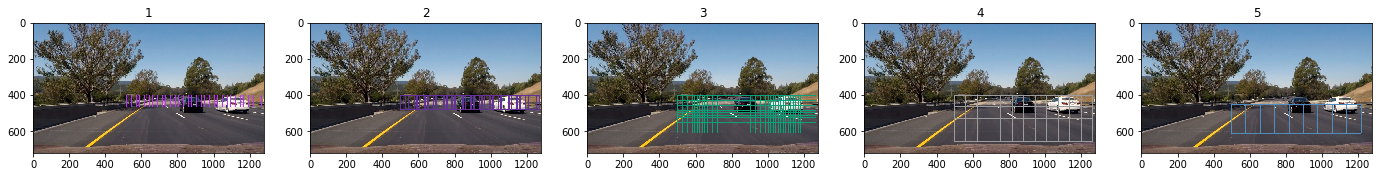

In [59]:
test_image = mpimg.imread('./test_images/test6.jpg')
windows = []

window1 = slide_window(test_image, x_start_stop=[500, None], y_start_stop=[400, 464], 
                xy_window=(64, 64), xy_overlap=(0.85, 0.85))
window2 = slide_window(test_image, x_start_stop=[500, None], y_start_stop=[400, 480], 
                    xy_window=(80, 80), xy_overlap=(0.80, 0.80))
window3 = slide_window(test_image, x_start_stop=[500, None], y_start_stop=[400, 612], 
                    xy_window=(96, 96), xy_overlap=(0.70, 0.70))
window4 = slide_window(test_image, x_start_stop=[500, None], y_start_stop=[400, 660], 
                    xy_window=(128, 128), xy_overlap=(0.50, 0.50))
window5 = slide_window(test_image, x_start_stop=[500, None], y_start_stop=[450, 670], 
                    xy_window=(160, 160), xy_overlap=(0.50, 0.50))


windows.extend(window1)
windows.extend(window2)
windows.extend(window3)
windows.extend(window4)
windows.extend(window5)

window_img1 = draw_boxes(np.copy(test_image), window1, color=(190, 50, 255), thick=1)
window_img2 = draw_boxes(np.copy(test_image), window2, color=(100, 50, 150), thick=2)
window_img3 = draw_boxes(np.copy(test_image), window3, color=(10, 160, 120), thick=2)
window_img4 = draw_boxes(np.copy(test_image), window4, color=(155, 155, 155), thick=3)
window_img5 = draw_boxes(np.copy(test_image), window5, color=(80, 140, 190), thick=3)
all_windows = draw_boxes(np.copy(test_image), windows, color=(0,0,255), thick=2)

fig = plt.figure(2,figsize=(24,9))
plt.subplot(151)
plt.imshow(window_img1)
plt.title('1')
plt.subplot(152)
plt.imshow(window_img2)
plt.title('2')
plt.subplot(153)
plt.imshow(window_img3)
plt.title('3')
plt.subplot(154)
plt.imshow(window_img4)
plt.title('4')
plt.subplot(155)
plt.imshow(window_img5)
plt.title('5')

plt.imsave('./output_images/window_size1.png',window_img1)
plt.imsave('./output_images/window_size2.png',window_img2)
plt.imsave('./output_images/window_size3.png',window_img3)
plt.imsave('./output_images/window_size4.png',window_img4)
plt.imsave('./output_images/window_size5.png',window_img5)
plt.imsave('./output_images/all_windows.png',all_windows)


### Test Images Pipeline

In [53]:
def testPipline(image):
    
    draw_img = np.copy(image)
    
    image = image.astype(np.float32)/255
    y_start_stop = [400, 670]
    hog_channel = 'ALL'
    windows = []


    window1 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 464], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    window2 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 480], 
                        xy_window=(80, 80), xy_overlap=(0.80, 0.80))
    window3 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 612], 
                        xy_window=(96, 96), xy_overlap=(0.70, 0.70))
    window4 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 660], 
                        xy_window=(128, 128), xy_overlap=(0.50, 0.50))
    window5 = slide_window(image, x_start_stop=[500, None], y_start_stop=[450, 670], 
                        xy_window=(160, 160), xy_overlap=(0.50, 0.50))


    windows.extend(window1)
    windows.extend(window2)
    windows.extend(window3)
    windows.extend(window4)
    windows.extend(window5)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=(spatial, spatial), hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, 
                            hist_feat=False, hog_feat=True)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)
 
    heat = add_heat(heat, hot_windows)
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label f
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return (draw_img,heatmap)

### Visualizing the output

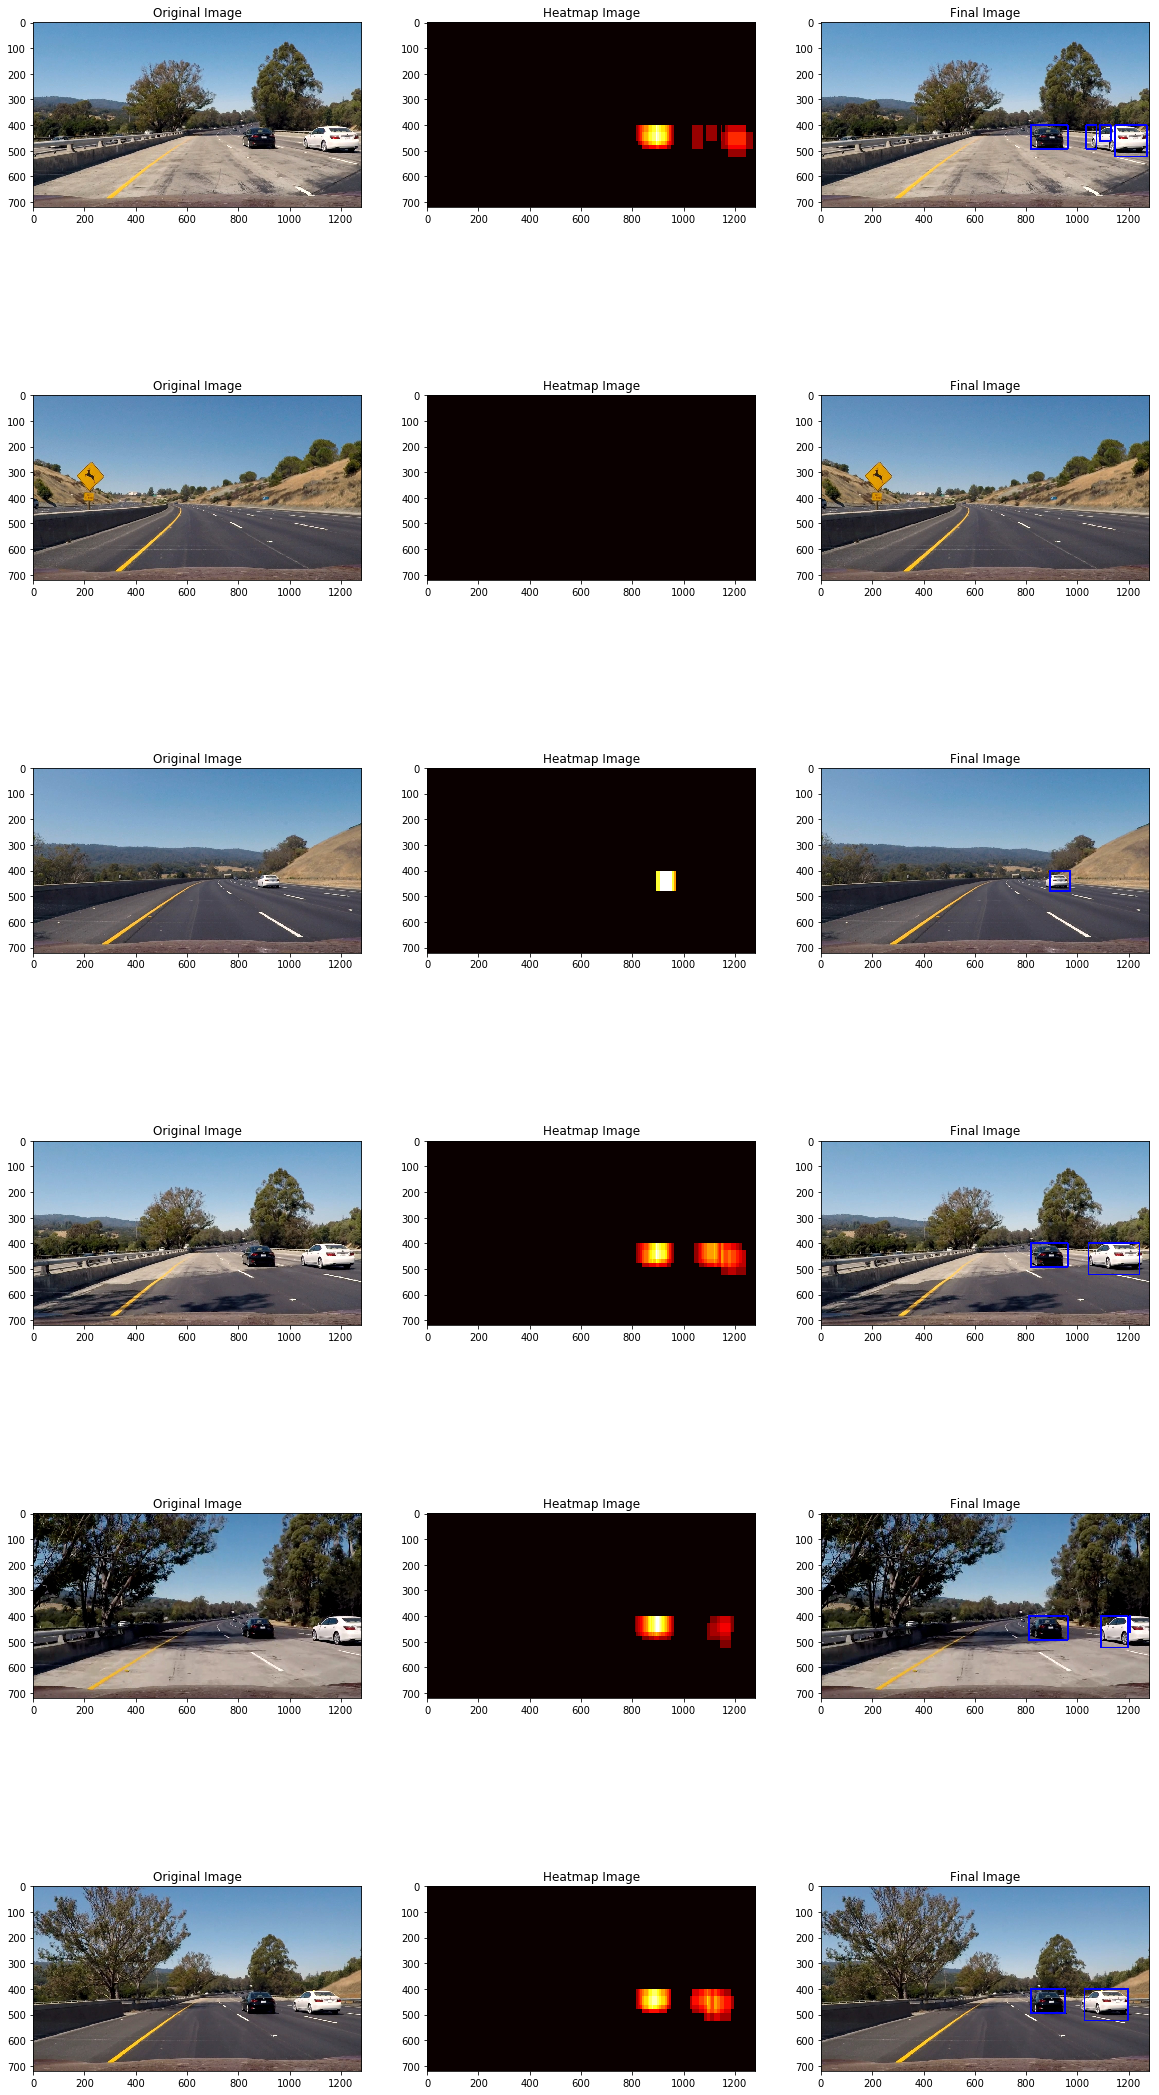

In [58]:
test_images = glob.glob('./test_images/*.jpg')

f, axes= plt.subplots(6,3, figsize=(20,40))

for index,image in enumerate(test_images):
    image = cv2.imread(image)    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    finalPic,heatmap = testPipline(image)
    axes[index,0].imshow(image)
    axes[index,0].set_title("Original Image")
    axes[index,1].imshow(heatmap,cmap='hot')
    axes[index,1].set_title("Heatmap Image")
    axes[index,2].imshow(finalPic)
    axes[index,2].set_title("Final Image")

f.savefig('./output_images/testResults.png')

# Video Pipeline

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [60]:
avg_windows = []
def videoPipeline(image):
    
    draw_img = np.copy(image)
    
    image = image.astype(np.float32)/255
    y_start_stop = [400, 670]
    hog_channel = 'ALL'
    windows = []


    window1 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 464], 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))
    window2 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 480], 
                        xy_window=(80, 80), xy_overlap=(0.80, 0.80))
    window3 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 612], 
                        xy_window=(96, 96), xy_overlap=(0.70, 0.70))
    window4 = slide_window(image, x_start_stop=[500, None], y_start_stop=[400, 660], 
                        xy_window=(128, 128), xy_overlap=(0.50, 0.50))
    window5 = slide_window(image, x_start_stop=[500, None], y_start_stop=[450, 670], 
                        xy_window=(160, 160), xy_overlap=(0.50, 0.50))


    windows.extend(window1)
    windows.extend(window2)
    windows.extend(window3)
    windows.extend(window4)
    windows.extend(window5)
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=(spatial, spatial), hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, 
                            hist_feat=False, hog_feat=True)                       

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    avg_windows.append(hot_windows)
    if len(avg_windows) >= 10:  
        for i in avg_windows[-10:]:
            heat = add_heat(heat, i)
        heat = apply_threshold(heat,16)
    else:
        heat = add_heat(heat, hot_windows)
        heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label f
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img

 

In [8]:
output_video = './output_video_final.mp4' 

clip1 = VideoFileClip("project_video.mp4")

video_clip = clip1.fl_image(videoPipeline) 
%time video_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video ./output_video_final.mp4
[MoviePy] Writing video ./output_video_final.mp4


100%|████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:40<00:01,  1.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video_final.mp4 

Wall time: 26min 42s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))